#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

#### This notebook does not include the raw data files. In order to run the notebook, you need to download them from https://fastmri.med.nyu.edu/

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [2]:
base_path = r"W:\fastMRI_brain\multicoil_train"
file_name = "file_brain_AXT2_210_6001944.h5"
full_path = os.path.join(base_path, file_name)
hf = h5py.File(full_path)

In [3]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'AXT2', 'max': 0.0007081719243083575, 'norm': 0.16223164878819385, 'patient_id': '9f1bb52e08717d5f753d9d076f101a7fd971d3f906c3ef8c318caad206891389'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [4]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(16, 20, 768, 396)


In [5]:
slice_kspace = volume_kspace[6] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [6]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

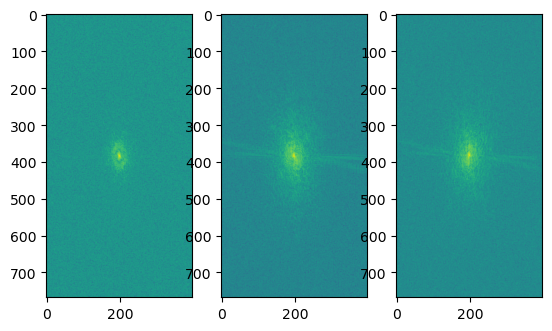

In [7]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [8]:
import fastmri
from fastmri.data import transforms as T

C:\Users\AIWM_PC\K-space\fastmri\__init__.py:16: UserWarning: Could not retrieve fastmri version!
  warnings.warn("Could not retrieve fastmri version!")


In [9]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

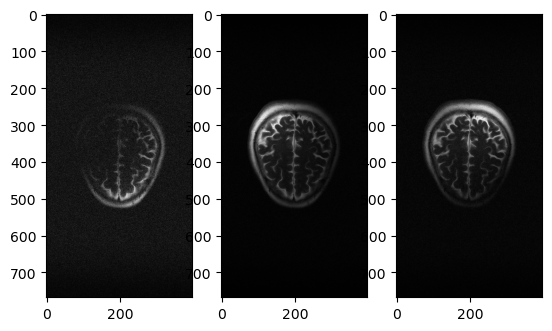

In [10]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [11]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

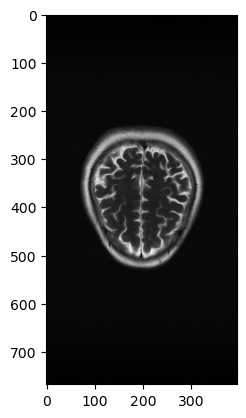

In [12]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [22]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[12])  # Create the mask function object

In [23]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Mask Shape after Squeeze: torch.Size([396])


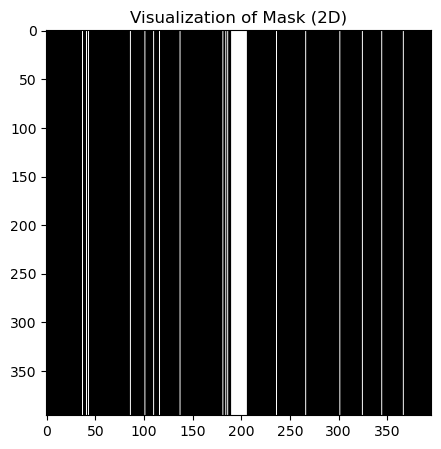

In [24]:
import torch
import matplotlib.pyplot as plt

# Remove singleton dimensions
mask_reshaped = mask.squeeze()  # Remove unnecessary dimensions
print("Mask Shape after Squeeze:", mask_reshaped.shape)

mask_2d = mask_reshaped.repeat(396, 1).numpy()  # Repeat along a new axis to make it 2D
plt.figure(figsize=(10, 5))
plt.imshow(mask_2d, cmap="gray")
plt.title("Visualization of Mask (2D)")
plt.show()

In [15]:
slice_kspace2.shape

torch.Size([20, 768, 396, 2])

Let's see what the subsampled image looks like:

In [16]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

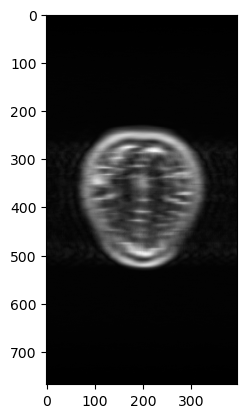

In [17]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')